In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import statsmodels.api as sm

from numpy import asarray
from sklearn.preprocessing import MinMaxScaler


pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
import pickle
#pd.reset_option('display.float_format')

In [2]:
data = pd.read_csv("./data/kc_house_data.csv")

# Misc Functions

In [3]:

def checkForColinearity(df_ColsToCheck):
    df=df_ColsToCheck.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    #zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    #set index to pairs
    df.set_index(['pairs'], inplace = True)

    #drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    #rename correlation column as cc rather than 0
    df.columns = ['cc']

    #drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
    df.drop_duplicates(inplace=True)
    df = df[(df.cc>.70) & (df.cc <1)]
    return df

def correlation_heatmap(df):
    _,ax=plt.subplots(figsize=(60,30))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(df.corr(),annot=True,cmap=colormap)

# Preprocessing

Ensure No Missing Values

waterfront      2376
view              63
yr_renovated    3842
dtype: int64


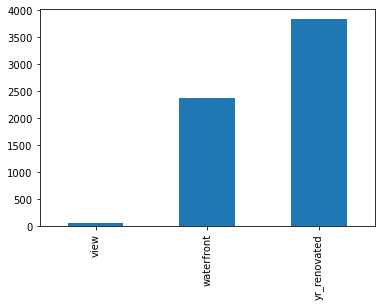

In [4]:
missing = data.isnull().sum()
missing = missing[missing > 0]
print (missing)
missing.sort_values(inplace=True)
missing.plot.bar();

In [5]:
#fill In Waterfront and View Nulls
data_No_NAs = data
data_No_NAs['waterfront'].fillna(data['waterfront'].mode()[0], inplace=True)
data_No_NAs['view'].fillna(data['view'].mode()[0], inplace=True)


#fill In Year Renovated and insert "Age of Home" (Today - Year Built) and "Years Since Renovated"
data_No_NAs["yr_renovated"].fillna(0, inplace=True)
data_No_NAs["yr_renovated"]  = data_No_NAs.apply(lambda row : (row['yr_built']) if row["yr_renovated"] == 0 else row["yr_renovated"], axis=1)
# data_No_NAs["YearsSinceRenovation"] = data_No_NAs.apply(lambda row : (2020 - row['yr_renovated']) if row["yr_renovated"] != 0 else (2020 - row["yr_built"]), axis=1)
data_No_NAs["AgeOfHome"] = (2020 - data_No_NAs["yr_built"])

#handle "?" in the sqrt basement column
data_No_NAs["sqft_basement"]  = data_No_NAs.apply(lambda row : 0 if row["sqft_basement"] == "?" else row["sqft_basement"], axis=1)
data_No_NAs["sqft_basement"] = data_No_NAs["sqft_basement"].astype('float')

data_No_NAs["zipcode_str"] = data_No_NAs["zipcode"].astype('str')
data_No_NAs['ZipFirst3'] = data_No_NAs["zipcode_str"].str[:3]
data_No_NAs = data_No_NAs.drop("zipcode_str", axis=1) 

In [6]:
df_check2 = data_No_NAs.loc[data_No_NAs.waterfront ==1]
len(df_check2)

146

In [7]:
data_No_NAs.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,65,981
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,69,981
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,87,980
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,1965.0,98136,47.5208,-122.393,1360,5000,55,981
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,33,980


In [8]:
df_check2 = data_No_NAs.loc[data_No_NAs.id ==8732030490]
df_check2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3
4252,8732030490,12/22/2014,261500.0,4,2.5,2460,7800,1.0,0.0,0.0,3,8,1500,960.0,1977,1977.0,98023,47.3081,-122.384,2210,7800,43,980


In [9]:
missing = data.isnull().sum()
missing

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
AgeOfHome        0
zipcode_str      0
ZipFirst3        0
dtype: int64

# <u> <font color='red'>Model 1 Dataset</font></u>

##    A. "Finding" Target Market

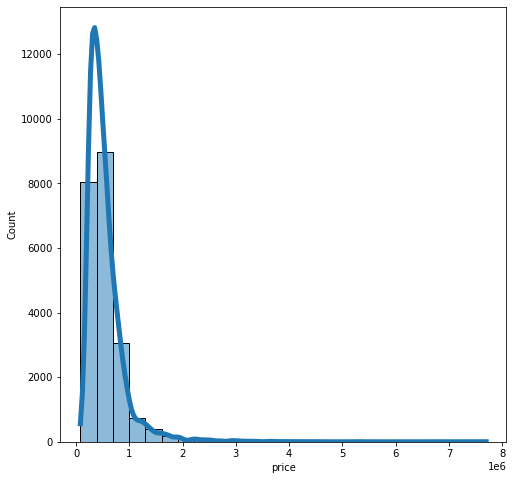

In [10]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "price",
             data=data_No_NAs,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

Majority of Homes Priced <$1,000,000

Establish Target Market --> Price Range That Contains Most Data Points 

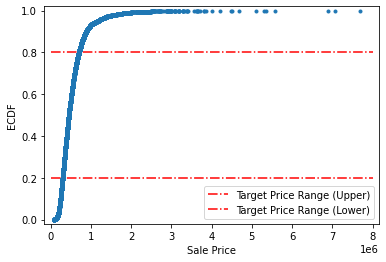

In [11]:
x = np.sort(data_No_NAs['price'])
y = np.arange(1, len(x)+1)/ len(x)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.hlines(.8, 0, 8000000, colors='red', linestyles='dashdot', label='Target Price Range (Upper)', data=None)
_ = plt.hlines(.2, 0, 8000000, colors='red', linestyles='dashdot', label='Target Price Range (Lower)', data=None)
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Sale Price')
plt.legend(loc="lower right")
plt.margins(.02) # keeps data from running off edge
plt.show()

In [12]:
pd.options.display.float_format = '{:,.0f}'.format
data_No_NAs.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome
count,"21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597","21,597"
mean,"4,580,474,288","540,297",3,2,"2,080","15,099",1,0,0,3,8,"1,789",286,"1,971","1,973","98,078",48,-122,"1,987","12,758",49
std,"2,876,735,716","367,368",1,1,918,"41,413",1,0,1,1,1,828,440,29,29,54,0,0,685,"27,274",29
min,"1,000,102","78,000",1,0,370,520,1,0,0,1,3,370,0,"1,900","1,900","98,001",47,-123,399,651,5
25%,"2,123,049,175","322,000",3,2,"1,430","5,040",1,0,0,3,7,"1,190",0,"1,951","1,954","98,033",47,-122,"1,490","5,100",23
50%,"3,904,930,410","450,000",3,2,"1,910","7,618",2,0,0,3,7,"1,560",0,"1,975","1,977","98,065",48,-122,"1,840","7,620",45
75%,"7,308,900,490","645,000",4,2,"2,550","10,685",2,0,0,4,8,"2,210",550,"1,997","1,999","98,118",48,-122,"2,360","10,083",69
max,"9,900,000,190","7,700,000",33,8,"13,540","1,651,359",4,1,4,5,13,"9,410","4,820","2,015","2,015","98,199",48,-121,"6,210","871,200",120


50% Data Points Between $645,000 - and #322,000, Remove Outliers on both sides and rerun, currently mean and standard deviation impacted significantly by large home values

In [13]:
lower = 250000
upper = 800000
log_lower = np.log(lower)
log_upper = np.log(upper)

data_No_NAs["log_price"] = np.log(data_No_NAs['price'])

q_high = data_No_NAs['log_price'].quantile(.85)
q_low = data_No_NAs['log_price'].quantile(.25)

q_high = log_upper
q_low = log_lower

data_Target_Homes = data_No_NAs[data_No_NAs['log_price']<q_high]
data_Target_Homes = data_Target_Homes[data_Target_Homes['log_price']>q_low]
data_Target_Homes.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price
count,"16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170","16,170"
mean,"4,647,897,508","467,108",3,2,"1,960","14,321",1,0,0,3,8,"1,688",266,"1,972","1,974","98,079",48,-122,"1,911","12,335",48,13
std,"2,874,291,078","144,243",1,1,680,"38,328",1,0,1,1,1,659,398,29,29,51,0,0,545,"26,144",29,0
min,"1,000,102","250,200",1,0,370,520,1,0,0,1,3,370,0,"1,900","1,900","98,001",47,-123,399,651,5,12
25%,"2,206,700,094","345,000",3,2,"1,460","4,895",1,0,0,3,7,"1,200",0,"1,952","1,954","98,034",47,-122,"1,500","5,000",22,13
50%,"3,982,700,188","445,000",3,2,"1,880","7,337",2,0,0,3,7,"1,530",0,"1,977","1,978","98,072",48,-122,"1,820","7,406",43,13
75%,"7,349,615,080","570,000",4,2,"2,390","10,140",2,0,0,4,8,"2,080",520,"1,998","1,999","98,118",48,-122,"2,250","9,736",68,13
max,"9,900,000,190","799,990",33,8,"5,820","1,651,359",4,1,4,5,11,"5,450","2,196","2,015","2,015","98,199",48,-121,"4,670","560,617",120,14


Mean now closer to 50%

Remove additional outliers Ex. bedrooms = 33 , Bathrooms < 8, Sqft_Lot <12000. > 4000, Homes that have sold more than 1 on target years

In [14]:
# data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['bedrooms'] < (7)] # > 10 Bedrooms
# data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['bathrooms'] < (6)]  # > 6 Bathrooms
data_Target_Homes = data_Target_Homes.loc[(4000 <= data_Target_Homes['sqft_lot']) & (data_Target_Homes['sqft_lot'] <= 12000)] #4000, 12000
data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['AgeOfHome'] < 50]
data_Target_Homes = data_Target_Homes.loc[(data_Target_Homes['sqft_basement'] >100) | (data_Target_Homes['waterfront']==1)]

In [15]:
df_check2 = data_Target_Homes.loc[data_Target_Homes.waterfront ==1]
len(df_check2)

1

In [16]:
df_check2 = data_Target_Homes.loc[data_Target_Homes.waterfront ==1]
df_check2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3,log_price
16556,2923039243,11/13/2014,"340,000",4,1,1200,11834,1,1,3,3,6,1200,0,1972,"1,972",98070,47,-122,1670,47462,48,980,13


In [17]:
# data_Target_Homes.zipcode.values_count()
# data_Target_Homes.set_index(["zipcode"]).count(level="zipcode")
print(data_Target_Homes.groupby('ZipFirst3')['waterfront'].sum())
print(data_Target_Homes.groupby('ZipFirst3')['price'].mean())
# data_Target_Homes.groupby('A')['B'].mean()

ZipFirst3
980   1
981   0
Name: waterfront, dtype: float64
ZipFirst3
980   452,337
981   474,657
Name: price, dtype: float64


In [18]:
(452512 - 475801)


-23289

In [19]:
data_Target_Homes.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price
count,"1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411","1,411"
mean,"4,927,383,417","457,763",4,2,"2,244","8,053",1,0,0,3,8,"1,521",723,"1,984","1,984","98,063",48,-122,"2,032","8,270",36,13
std,"2,857,145,507","144,669",1,1,632,"1,865",0,0,1,1,1,490,298,11,11,50,0,0,476,"2,489",11,0
min,"11,300,120","250,600",1,1,"1,040","4,000",1,0,0,2,6,580,0,"1,971","1,971","98,001",47,-122,930,"1,499",5,12
25%,"2,473,410,525","330,000",3,2,"1,790","7,032",1,0,0,3,7,"1,210",500,"1,977","1,977","98,030",47,-122,"1,720","7,228",31,13
50%,"4,099,100,260","440,000",4,2,"2,120","7,930",1,0,0,3,8,"1,380",690,"1,979","1,979","98,052",48,-122,"1,960","8,022",41,13
75%,"7,695,610,150","555,000",4,3,"2,530","9,525",1,0,0,4,8,"1,665",900,"1,989","1,989","98,092",48,-122,"2,270","9,551",43,13
max,"9,839,300,775","799,950",8,5,"5,110","12,000",3,1,4,5,10,"3,850","2,170","2,015","2,015","98,199",48,-121,"4,410","47,462",49,14


In [20]:
#Remove Homes That have sold More Than Twice In the Same year (Flipper Homes)
df_housesThatSoldTwice = data_Target_Homes.groupby('id').count().reset_index().sort_values(by="date", ascending=False)
df_housesThatSoldTwice = df_housesThatSoldTwice[df_housesThatSoldTwice["date"] > 1]
data_Target_Homes = data_Target_Homes.merge(df_housesThatSoldTwice[['id','date']], on="id", how='left')
data_Target_Homes.date_y.fillna(0, inplace=True)
data_Target_Homes = data_Target_Homes[data_Target_Homes["date_y"]==0]
data_Target_Homes = data_Target_Homes.drop(['date_y'], axis=1)
data_Target_Homes.rename(columns={"date_x":"date"}, inplace=True)

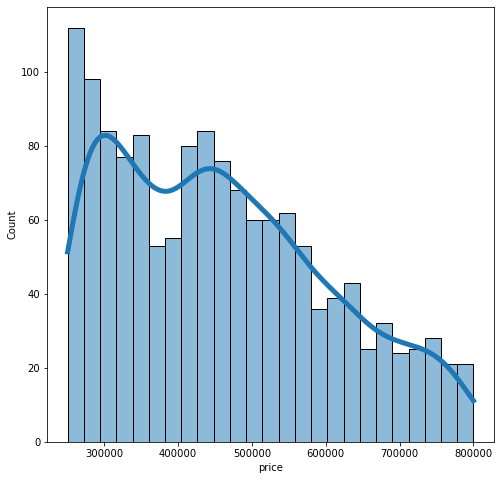

In [21]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

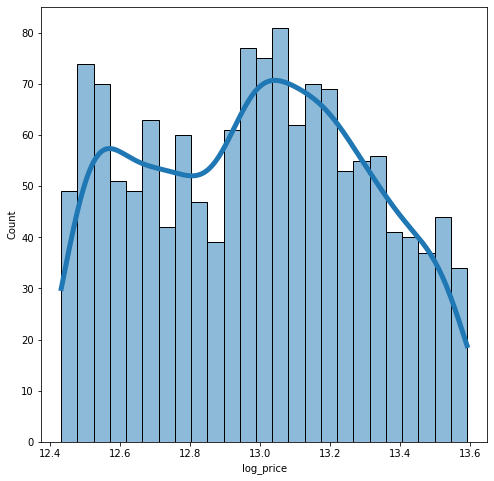

In [22]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "log_price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

In [23]:
data_Target_Homes.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price
count,"1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399","1,399"
mean,"4,927,771,221","458,006",4,2,"2,246","8,045",1,0,0,3,8,"1,523",723,"1,984","1,984","98,063",48,-122,"2,031","8,258",36,13
std,"2,850,450,380","144,687",1,1,633,"1,858",0,0,1,1,1,491,298,11,11,50,0,0,476,"2,493",11,0
min,"11,300,120","250,600",1,1,"1,040","4,000",1,0,0,2,6,580,0,"1,971","1,971","98,001",47,-122,930,"1,499",5,12
25%,"2,473,410,885","330,000",3,2,"1,790","7,024",1,0,0,3,7,"1,213",500,"1,977","1,977","98,030",47,-122,"1,720","7,223",31,13
50%,"4,099,100,260","440,000",4,2,"2,120","7,923",1,0,0,3,8,"1,390",690,"1,979","1,979","98,052",48,-122,"1,960","8,008",41,13
75%,"7,689,200,203","556,250",4,3,"2,530","9,516",1,0,0,4,8,"1,670",900,"1,989","1,989","98,092",48,-122,"2,270","9,533",43,13
max,"9,839,300,775","799,950",8,5,"5,110","12,000",3,1,4,5,10,"3,850","2,170","2,015","2,015","98,199",48,-121,"4,410","47,462",49,14


##    B. Scaling, Converting & Eliminating Multicolinearity

In [24]:
model1_Continuous_variables  = ['bedrooms', 'bathrooms','sqft_lot', 'floors', 
                                                  'sqft_above', 'sqft_basement', 'sqft_living15', 'AgeOfHome']

data_Target_Homes_Continuous = data_Target_Homes[model1_Continuous_variables]
# model1_Continuous_variables = data_Target_Homes_Continuous.columns

In [25]:
# define min max scaler
scaler = MinMaxScaler()

# transform data
scaled_df = scaler.fit_transform(data_Target_Homes_Continuous)
scaled_df = pd.DataFrame(scaled_df, columns=data_Target_Homes_Continuous.columns)
scaled_df_no_index = scaled_df.reset_index(drop=True)

Convert Categorical To Dummy

In [26]:
# categoricals = ['waterfront', 'view', 'condition', 'grade']
# dummies = pd.get_dummies(data_with_Ap_Hot_Dist_POints[categoricals], prefix=categoricals, drop_first=True)

dummies_3digitZip = pd.get_dummies(data_Target_Homes['ZipFirst3'], prefix='ZipFirst3', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('ZipFirst3', axis=1)

dummies_water = pd.get_dummies(data_Target_Homes['waterfront'], prefix='waterfront', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('waterfront', axis=1)

dummies_view = pd.get_dummies(data_Target_Homes['view'], prefix='view', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('view', axis=1)

dummies_condition = pd.get_dummies(data_Target_Homes['condition'], prefix='condition', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('condition', axis=1)

dummies_grade = pd.get_dummies(data_Target_Homes['grade'], prefix='grade', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('grade', axis=1)



data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes, dummies_water], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_3digitZip], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_view], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_condition], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_grade], axis=1)

data_Target_Homes_Not_Scaled_WithDummies.rename(columns={'waterfront_1.0': 'waterfront_1', 'view_1.0': 'view_1',
                'view_1.0':'view_1', 'view_2.0':'view_2', 'view_3.0':'view_3', 'view_4.0':'view_4'}, inplace=True)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Not_Scaled_WithDummies.drop(['bedrooms', 'bathrooms',
                                                                                      'sqft_living',
                                                                                      'sqft_lot', 'floors', 
                                                                                      'sqft_above', 
                                                                                      'sqft_basement',
                                                                                      'sqft_living15', 
                                                                                      'sqft_lot15',
                                                                                      'AgeOfHome'],
                                                                                     axis = 1)
data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies.reset_index(drop=True)
data_Target_Homes_Scaled_WithDummies = pd.concat([data_Target_Homes_Scaled_WithDummies, scaled_df_no_index], axis=1)

In [27]:
data_Target_Homes_Scaled_WithDummies.head()

,id,date,price,yr_built,yr_renovated,zipcode,lat,long,log_price,waterfront_1,ZipFirst3_981,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_7,grade_8,grade_9,grade_10,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,AgeOfHome
0,9297300055,1/24/2015,"650,000",1979,"1,979",98126,48,-122,13,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1,7955080270,12/3/2014,"322,500",1981,"1,981",98058,47,-122,13,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,3626039271,2/5/2015,"585,000",1981,"1,981",98117,48,-122,13,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
3,1189001180,6/3/2014,"425,000",1979,"1,979",98122,48,-122,13,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,3342103156,6/18/2014,"461,000",2006,"2,006",98056,48,-122,13,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [28]:
model1_Constantants = ['id,','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']

model1_Categorical_variables = ['waterfront_1', 'view_1', 
                                'view_2', 'view_3', 'view_4', 
                                'condition_2', 'condition_3','condition_4', 'condition_5', 'grade_5','grade_6',
                                'grade_7','grade_8', 'grade_9', 'grade_10','grade_11', 'ZipFirst3_981']
#

Next Find Correlation and Mulicolinearity

In [29]:
model1_Categorical_variables_to_remove = ['grade_5','grade_6','condition_3', 'condition_2', 'grade_11']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['NA']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

,cc
pairs,
"(grade_7, grade_8)",1
"(sqft_above, floors)",1


In [30]:
model1_Categorical_variables_to_remove = ['grade_7']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['floors']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]


#Create Dataframefor Correlation check
colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

,cc
pairs,


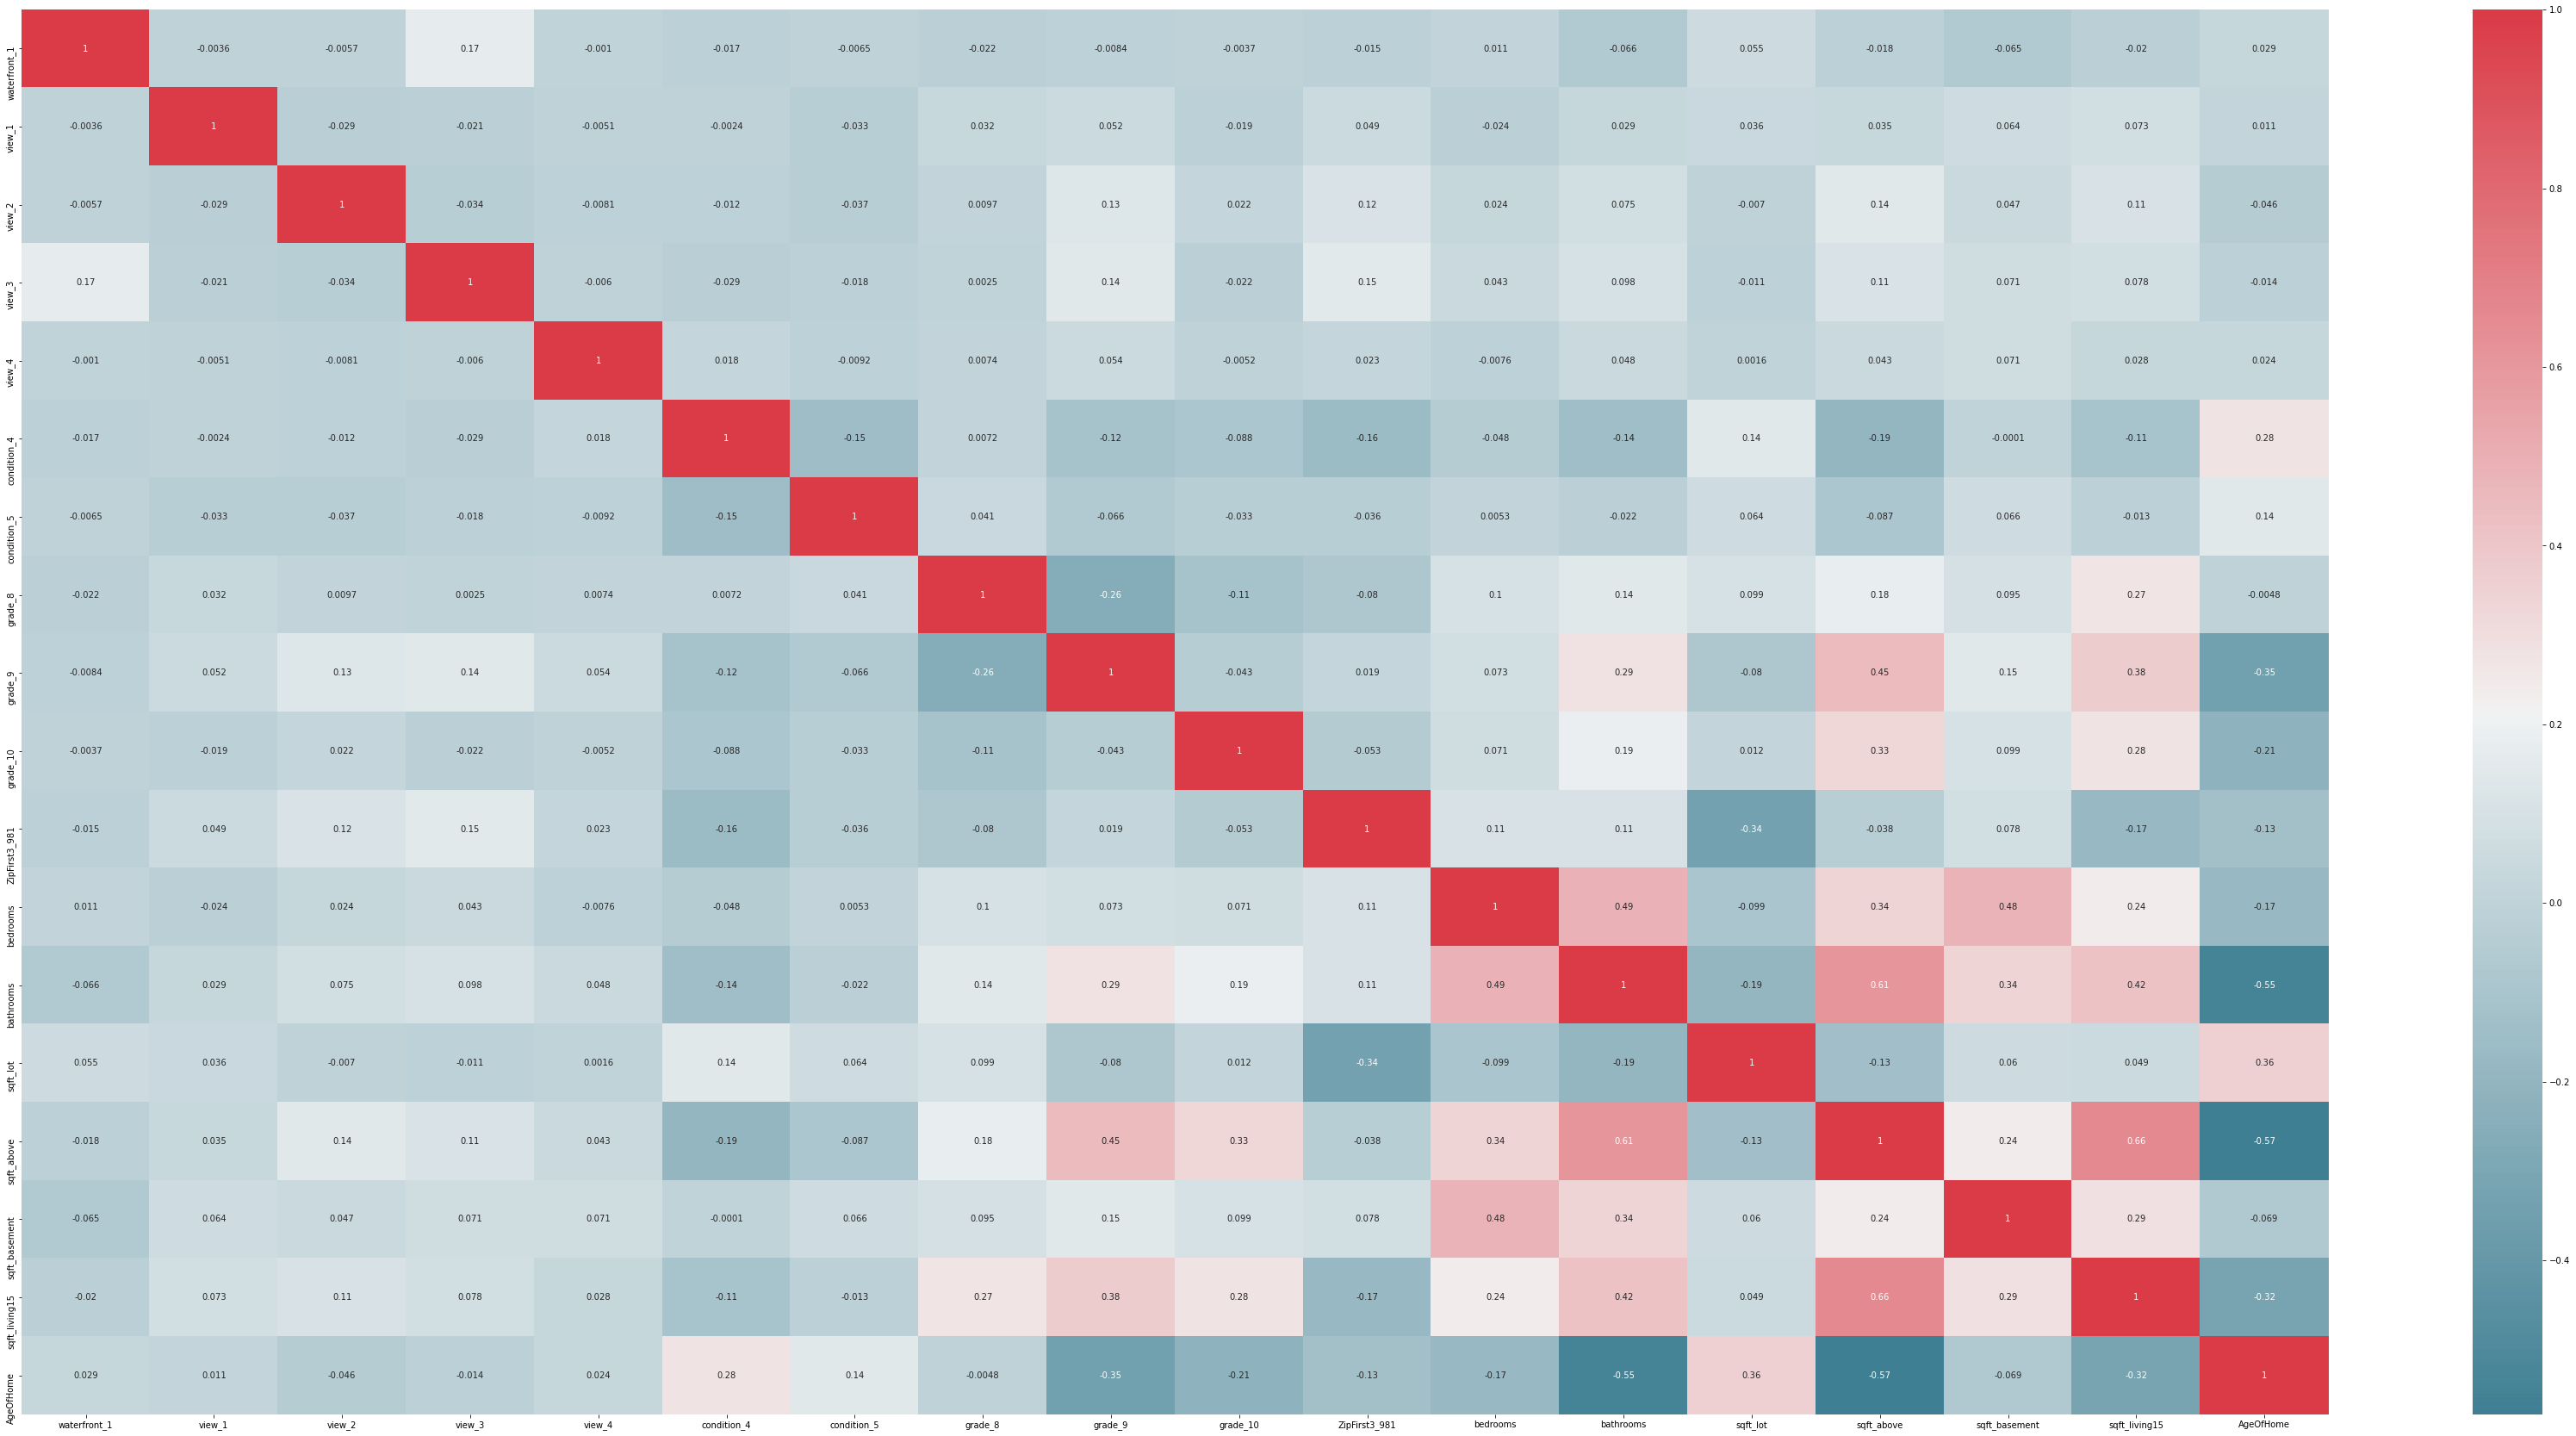

In [31]:
correlation_heatmap(data_Review_Colinearity_Model1)

##    C. Create Pickle of Dataset

Get All needed fields ready for Pickle file

In [32]:
FieldsMovingForward = ['id', 'price','log_price','date', 'zipcode', 'lat','long'] 
FieldsMovingForward.extend(data_Review_Colinearity_Model1.columns)
data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies[FieldsMovingForward]

Create Pickle File for testing Initial Model

In [33]:
with open('regression_Data_Initial_Model.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Scaled_WithDummies, f)

with open('regression_Data_xref.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Not_Scaled_WithDummies, f)

In [34]:
pd.reset_option('display.float_format')
data_Target_Homes_Scaled_WithDummies.describe()

,id,price,log_price,zipcode,lat,long,waterfront_1,view_1,view_2,view_3,view_4,condition_4,condition_5,grade_8,grade_9,grade_10,ZipFirst3_981,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,sqft_living15,AgeOfHome
count,1.399000e+03,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000
mean,4.927771e+09,458005.994282,12.984810,98063.287348,47.560145,-122.202789,0.000715,0.017870,0.043603,0.024303,0.001430,0.288063,0.055754,0.403860,0.090064,0.018585,0.243746,0.380272,0.389900,0.505617,0.288444,0.333004,0.316345,0.701670
std,2.850450e+09,144686.999950,0.316960,49.664385,0.149911,0.121132,0.026736,0.132526,0.204282,0.154043,0.037796,0.453022,0.229528,0.490845,0.286376,0.135101,0.429494,0.115326,0.133241,0.232303,0.150305,0.137319,0.136755,0.250578
min,1.130012e+07,250600.000000,12.431613,98001.000000,47.193700,-122.456000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.473411e+09,330000.000000,12.706848,98030.000000,47.443550,-122.298000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.294118,0.378063,0.193578,0.230415,0.227011,0.590909
50%,4.099100e+09,440000.000000,12.994530,98052.000000,47.555200,-122.194000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.411765,0.490375,0.247706,0.317972,0.295977,0.818182
75%,7.689200e+09,556250.000000,13.228971,98092.000000,47.705950,-122.139000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.428571,0.470588,0.689562,0.333333,0.414747,0.385057,0.863636
max,9.839301e+09,799950.000000,13.592305,98199.000000,47.777200,-121.417000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# <u><font color='red'>Model 2 Dataset</font></u>

##    A. Adding Features - Location Based

Add additional Location Based features - Zip HotnessScores (HotnessScore), Count of Attractions with 7 miles of home(#1,#2,#3 attractions), School district for home and its rank (SchoolDistRank)

In [35]:
# Get Data From Above - Build Upon Model 1
with open('regression_Data_Initial_Model.pickle', 'rb') as file:
    data_Model2 = pickle.load(file)

In [36]:
#get Hotness Scores
df_Hotness_Zone = pd.read_excel("./data/ZIP_cube_HotnessZones.xlsx")
data_with_Hot = data_Model2.merge(df_Hotness_Zone[["zipcode","HotnessScore"]], on="zipcode", how="left")

#get School District & Rank
df_School_District_Info = pd.read_excel('./data/df_SchoolDistricts_SchoolDigger - all.xlsx', sheet_name='Export')
df_School_District_Ranking = pd.read_excel('./data/SchoolDisctrictRank.xlsx', sheet_name='Export')
df_School_Districts_withRank = df_School_District_Info.merge(df_School_District_Ranking, on="School District")
data_with_Hot_Dist = data_with_Hot.merge(df_School_Districts_withRank[["id","State Rank"]], on="id")
data_with_Hot_Dist.rename(columns={"State Rank": "SchoolDistRank"})

#get points of interest within 7 miles
df_Points_Of_Interest = pd.read_excel('./ScrapedData/df_points_of_int_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist.merge(df_Points_Of_Interest, on="id")
data_with_Hot_Dist_POints.rename(columns={1: "#1Attractions", 2: "#2Attractions", 3: "#3Attractions"}, inplace=True)
# fill in attraction columns 
data_with_Hot_Dist_POints['#1Attractions'].fillna(0, inplace=True)
data_with_Hot_Dist_POints['#2Attractions'].fillna(0, inplace=True)

data_with_Hot_Dist_POints.rename(columns={'#1Attractions':'Attractions1', '#2Attractions':'Attractions2', '#3Attractions':'Attractions3',
                         'State Rank':'SchoolDistRank', 'HotnessScore':'ZipHotnessScore'}, inplace=True)

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [37]:
model2_Continuous_variables  = ['SchoolDistRank','ZipHotnessScore',
                                                         'Attractions1', 'Attractions2', 'Attractions3']

data_with_Hot_Dist_POints_Continuous = data_with_Hot_Dist_POints[model2_Continuous_variables]

In [38]:
# define min max scaler
scaler = MinMaxScaler()

# transform data
scaled_df2 = scaler.fit_transform(data_with_Hot_Dist_POints_Continuous)
scaled_df2 = pd.DataFrame(scaled_df2, columns=data_with_Hot_Dist_POints_Continuous.columns)
scaled_df_no_index2 = scaled_df2.reset_index(drop=True)

In [39]:
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.drop(model2_Continuous_variables, axis=1)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.reset_index(drop=True)
data_with_Hot_Dist_POints = pd.concat([data_with_Hot_Dist_POints, scaled_df_no_index2], axis=1)

Check For Colinearity

In [40]:
model2_Categorical_variables_to_remove = ['NA']
model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['NA']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

,cc
pairs,
"(Attractions3, Attractions1)",0.956340
"(Attractions2, Attractions3)",0.945539
"(Attractions2, Attractions1)",0.916205
"(ZipFirst3_981, ZipHotnessScore)",0.719779


In [41]:
model2_Categorical_variables_to_remove = ["ZipFirst3_981"]
model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['Attractions2','Attractions3']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

,cc
pairs,


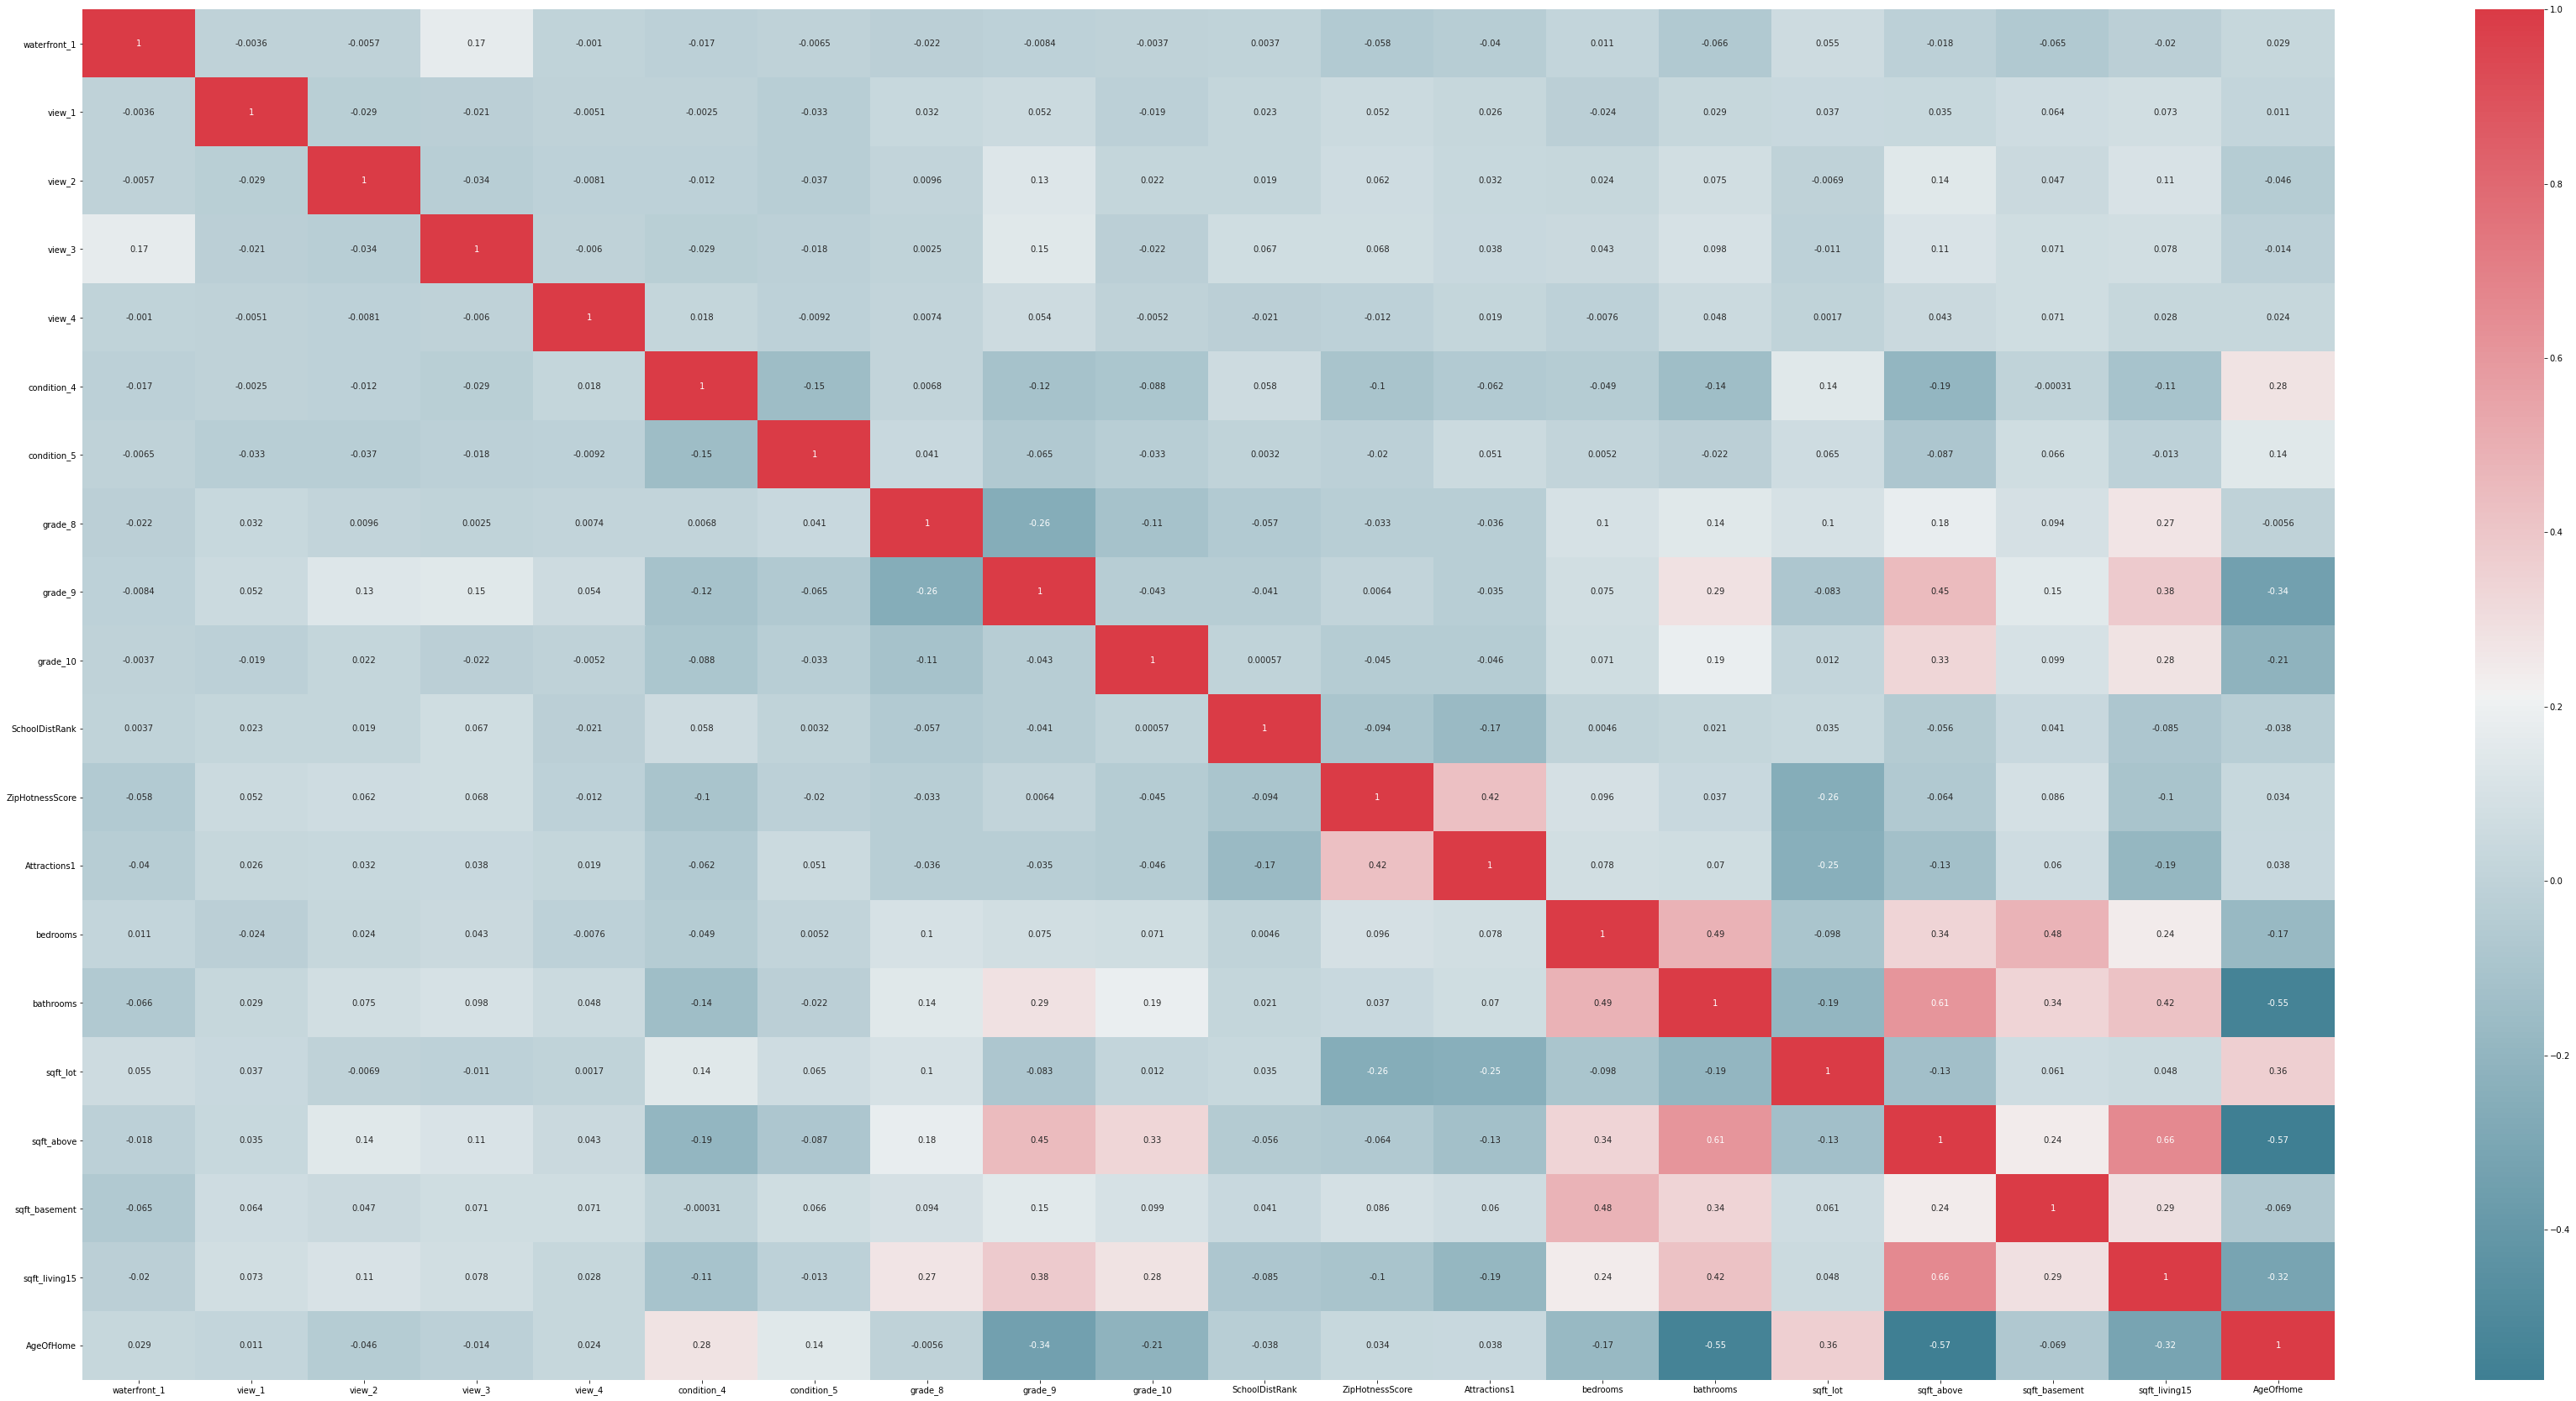

In [42]:
correlation_heatmap(data_Review_Colinearity_Model2)

##     C. Create Pickle of Dataset

In [43]:
FieldsMovingForward = ['id', 'log_price','date', 'zipcode', 'lat','long'] 
FieldsMovingForward.extend(data_Review_Colinearity_Model2.columns)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints[FieldsMovingForward]

In [44]:
import pickle
# Save
with open('regression_Data_Second_Model.pickle', 'wb') as f:
    pickle.dump(data_with_Hot_Dist_POints, f)

# <u> <font color='red'>Model 3 Dataset</font> </u>

## A. Adding Features - Previous Year Assesor Values

Add additional previous yr county assessor valuation - AppraisedLandValue, AppraisedImpsValue(aka house value), LandToHouseCheck, InflationSinceLastAppraisal

In [45]:
# Get Data From Above - Build Upon Model 2

# Load Data From Pickel
with open('regression_Data_Second_Model.pickle', 'rb') as file:
    data_Model3 = pickle.load(file)

In [46]:
from dateutil.relativedelta import relativedelta

data_Model3['salesyear'] = pd.DatetimeIndex(data_Model3['date']).year
data_Model3['yearpriortosale'] = data_Model3['salesyear'] - 1

data_Model3["salesyear_str"] = data_Model3["salesyear"].astype('str')
data_Model3["id_str"] = data_Model3["id"].astype('str')
data_Model3['appraisalKey'] = data_Model3['id_str'] + data_Model3['salesyear_str']

#get Appraisal Data - inner join to eleminate valus with no appraisals
df_Appraisal_Info = pd.read_excel('./data/Appraisals_Values_Table_w_3yrRolling.xlsx')
df_Appraisal_Info["appraisalKey"] = df_Appraisal_Info["appraisalKey"].astype('str')
df_data_with_Appraisals = data_Model3.merge(df_Appraisal_Info[['YrRollingAppraisal','AppraisedLandValue','AppraisedImpsValue','LandToHouseCheck','InflationSinceLastAppraisal','InflationSinceLastAppraisal_abs','appraisalKey']], on="appraisalKey", how="inner")

df_data_with_Appraisals.drop(['appraisalKey', 'id_str', 'salesyear', 'salesyear_str'], axis=1, inplace=True)

In [47]:
df_data_with_Appraisals.describe()

,id,log_price,zipcode,lat,long,waterfront_1,view_1,view_2,view_3,view_4,condition_4,condition_5,grade_8,grade_9,grade_10,SchoolDistRank,ZipHotnessScore,Attractions1,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,sqft_living15,AgeOfHome,yearpriortosale,YrRollingAppraisal,AppraisedLandValue,AppraisedImpsValue,LandToHouseCheck,InflationSinceLastAppraisal,InflationSinceLastAppraisal_abs
count,1.330000e+03,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000
mean,5.158778e+09,12.981592,98062.500000,47.558753,-122.202059,0.000752,0.018045,0.042105,0.025564,0.001504,0.288722,0.056391,0.407519,0.089474,0.017293,0.307651,0.599035,0.390415,0.381740,0.390756,0.509443,0.289102,0.332956,0.317352,0.701726,2013.334586,325561.646617,171412.781955,233796.240602,0.412059,0.156504,0.166593
std,2.730921e+09,0.316418,49.629481,0.150471,0.118960,0.027420,0.133165,0.200905,0.157890,0.038764,0.453339,0.230762,0.491558,0.285534,0.130411,0.343872,0.188873,0.172382,0.115123,0.134047,0.232592,0.150724,0.136713,0.136914,0.249419,0.472023,110603.953577,91346.726907,91775.840786,0.126261,0.717038,0.714759
min,1.015500e+09,12.431613,98001.000000,47.193700,-122.456000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002874,0.000000,2013.000000,56333.000000,51000.000000,6000.000000,0.104825,-0.304296,0.000000
25%,2.598253e+09,12.706848,98029.250000,47.443475,-122.297000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.462135,0.288062,0.285714,0.294118,0.383969,0.192661,0.230415,0.227011,0.590909,2013.000000,235667.000000,97000.000000,172000.000000,0.320267,0.071429,0.074419
50%,4.404600e+09,12.994530,98052.000000,47.554350,-122.194000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156863,0.597210,0.382353,0.428571,0.411765,0.495375,0.247706,0.317972,0.295977,0.818182,2013.000000,310333.500000,148000.000000,211000.000000,0.387440,0.119025,0.123411
75%,7.809960e+09,13.225597,98074.000000,47.706675,-122.138000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.705882,0.710972,0.500865,0.428571,0.470588,0.693219,0.333333,0.418203,0.385057,0.863636,2014.000000,390500.250000,224750.000000,268000.000000,0.493858,0.162305,0.162791
max,9.839301e+09,13.592305,98199.000000,47.777200,-121.742000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.953917,1.000000,1.000000,2014.000000,736333.000000,613000.000000,720000.000000,0.984848,18.200000,18.200000


In [48]:
#Remove addtiaional outliers, "abnarmally" expensive, big, etc. homes 
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['LandToHouseCheck'] <= .6]
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['InflationSinceLastAppraisal_abs'] <= .2]

In [49]:
df_data_with_Appraisals.describe()

,id,log_price,zipcode,lat,long,waterfront_1,view_1,view_2,view_3,view_4,condition_4,condition_5,grade_8,grade_9,grade_10,SchoolDistRank,ZipHotnessScore,Attractions1,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,sqft_living15,AgeOfHome,yearpriortosale,YrRollingAppraisal,AppraisedLandValue,AppraisedImpsValue,LandToHouseCheck,InflationSinceLastAppraisal,InflationSinceLastAppraisal_abs
count,1.059000e+03,1059.000000,1059.000000,1059.000000,1059.000000,1059.0,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.00000,1059.000000,1059.000000,1059.000000
mean,5.104499e+09,12.964008,98062.050992,47.554511,-122.204067,0.0,0.016053,0.032106,0.021719,0.001889,0.288952,0.054769,0.398489,0.088763,0.018886,0.315901,0.608259,0.389497,0.384864,0.392435,0.496793,0.291759,0.335698,0.318246,0.702850,2013.238905,320825.931067,158085.930123,237167.13881,0.393987,0.089640,0.100547
std,2.771848e+09,0.313727,48.651778,0.150076,0.116139,0.0,0.125738,0.176364,0.145832,0.043437,0.453490,0.227636,0.489818,0.284536,0.136186,0.339475,0.182160,0.169328,0.115440,0.129953,0.228514,0.151380,0.132866,0.138394,0.245144,0.426616,109017.670989,72596.999711,88273.14873,0.096693,0.068819,0.051571
min,1.015500e+09,12.431613,98001.000000,47.194200,-122.456000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000,0.000000,0.058824,0.000000,0.003058,0.059908,0.002874,0.000000,2013.000000,56333.000000,51000.000000,87000.00000,0.110473,-0.185185,0.000000
25%,2.558680e+09,12.691580,98029.000000,47.442100,-122.298000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.496457,0.297578,0.285714,0.294118,0.375000,0.195719,0.230415,0.232759,0.590909,2013.000000,232500.000000,96000.000000,178000.00000,0.320733,0.052632,0.067931
50%,4.222310e+09,12.983101,98052.000000,47.546300,-122.193000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156863,0.597210,0.380623,0.428571,0.411765,0.475875,0.247706,0.322581,0.293103,0.818182,2013.000000,304333.000000,141000.000000,216000.00000,0.383249,0.097345,0.098802
75%,7.852705e+09,13.208541,98077.000000,47.709250,-122.139000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.598039,0.713242,0.477509,0.428571,0.470588,0.679688,0.333333,0.419355,0.383621,0.863636,2013.000000,381500.000000,199000.000000,269500.00000,0.466161,0.140175,0.140664
max,9.839301e+09,13.591116,98199.000000,47.777200,-121.744000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.880184,1.000000,1.000000,2014.000000,736333.000000,445000.000000,720000.00000,0.597598,0.200000,0.200000


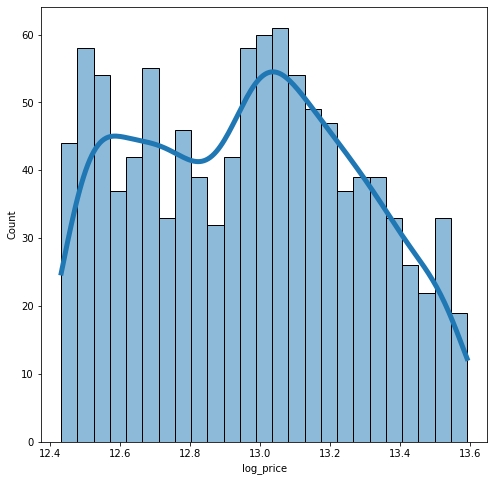

In [50]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "log_price",
             data=df_data_with_Appraisals,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [51]:
model3_Continuous_variables  = ['YrRollingAppraisal','AppraisedLandValue', 
                                  'AppraisedImpsValue', 'LandToHouseCheck',
                                  'InflationSinceLastAppraisal', 
                                  'InflationSinceLastAppraisal_abs']


data_with_Appraisals_Continuous = df_data_with_Appraisals[model3_Continuous_variables]

In [52]:
# define min max scaler
scaler = MinMaxScaler()

# transform data
scaled_df3 = scaler.fit_transform(data_with_Appraisals_Continuous)
scaled_df3 = pd.DataFrame(scaled_df3, columns=data_with_Appraisals_Continuous.columns)
scaled_df_no_index3 = scaled_df3.reset_index(drop=True)

In [53]:
df_data_with_Appraisals = df_data_with_Appraisals.drop(model3_Continuous_variables, axis=1)
df_data_with_Appraisals = df_data_with_Appraisals.reset_index(drop=True)
df_data_with_Appraisals = pd.concat([df_data_with_Appraisals, scaled_df_no_index3], axis=1)

Check For Colinearity

In [54]:
model3_Categorical_variables_to_remove = ['NA']
model3_Categorical_variables = model2_Categorical_variables
model3_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model3_Categorical_variables_to_remove)]

model3_Continuous_variables_to_remove = ['NA']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Categorical_variables + model3_Continuous_variables + model2_Continuous_variables + model1_Continuous_variables

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

,cc
pairs,
"(AppraisedImpsValue, YrRollingAppraisal)",0.804702
"(AppraisedLandValue, YrRollingAppraisal)",0.786721
"(InflationSinceLastAppraisal_abs, InflationSinceLastAppraisal)",0.781351
"(sqft_above, AppraisedImpsValue)",0.745545


In [55]:
model1_Continuous_variables_to_remove_v1 = ['NA']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove_v1)]

model3_Categorical_variables_to_remove = ['NA']
model3_Categorical_variables = model2_Categorical_variables
model3_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model3_Categorical_variables_to_remove)]

model3_Continuous_variables_to_remove = ['YrRollingAppraisal','InflationSinceLastAppraisal_abs','AppraisedImpsValue']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Categorical_variables + model3_Continuous_variables + model2_Continuous_variables + model1_Continuous_variables

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

,cc
pairs,


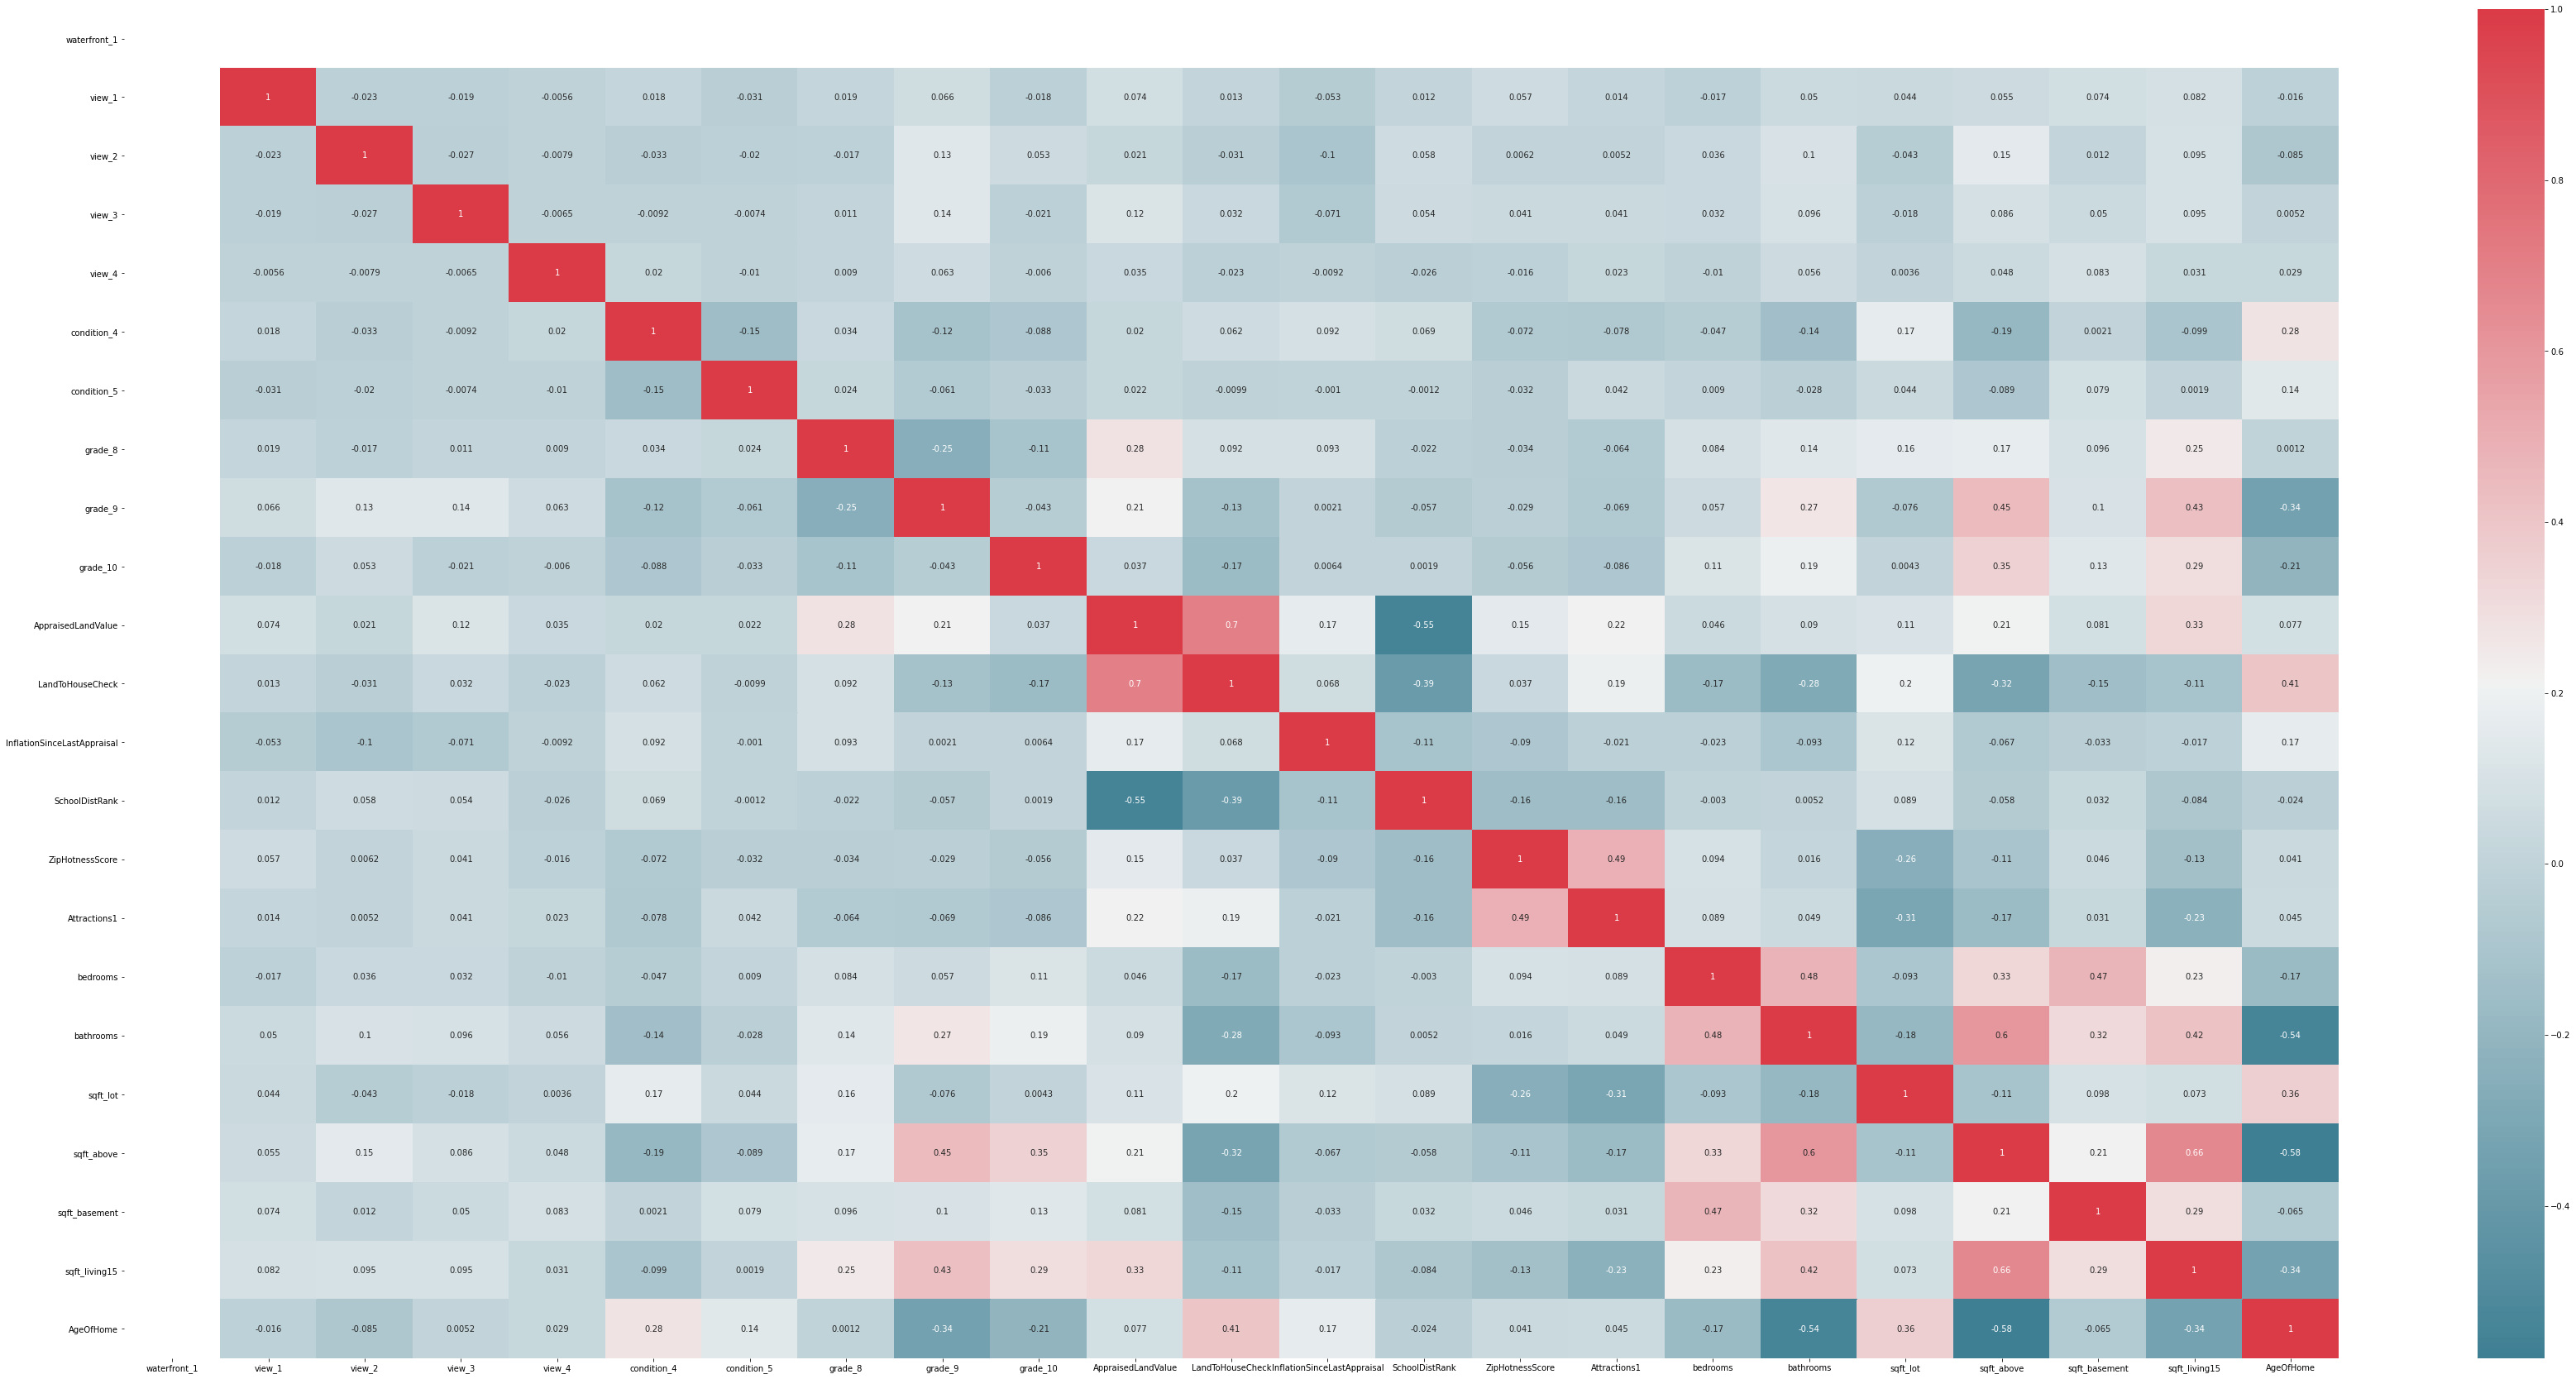

In [56]:
correlation_heatmap(data_Review_Colinearity_Model3)

## C. Create Pickle of Dataset

In [57]:
FieldsMovingForward = ['id', 'log_price','date', 'zipcode', 'lat','long'] 
FieldsMovingForward.extend(data_Review_Colinearity_Model3.columns)
df_data_with_Appraisals = df_data_with_Appraisals[FieldsMovingForward]

In [58]:
import pickle
# Save
with open('regression_Data_Third_Model.pickle', 'wb') as f:
    pickle.dump(df_data_with_Appraisals, f)

# Ensure linearity of features(independent) to target(dependent)

In [ ]:
data_No_Outliers["price"].describe().apply("${0:,.0f}".format)
#"Average" - middle class houses between 367k& 638$k

In [ ]:
data_pred = data_No_Outliers[['YrRollingAppraisal','AppraisedLandValue', 'AppraisedImpsValue', 'LandToHouseCheck',
       'InflationSinceLastAppraisal','bedrooms', 'bathrooms', 'sqft_living',
                                          'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
                                          'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15','YearsSinceRenovation', 'AgeOfHome', 
                                          'price', 'HotnessScore', 'State Rank','#1Attractions', 
                                          '#2Attractions', '#3Attractions']]

plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)

for index, column in enumerate(data_pred):

    if column != "price":
        ax = plt.subplot(6, 5, index+1)
        sns.regplot(x=column, y="price", data=data_No_Outliers, ax=ax, label='medium', line_kws={"color": "red"});
        plt.ticklabel_format(style='plain', axis='both')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
    
plt.show();
